# Hypotheses and Corresponding t-tests for White vs. Red Wine
DataSource = https://www.kaggle.com/datasets/subhajournal/wine-quality-data-combined

In [1]:
# Import libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


pd.set_option("display.max_columns", 75)


In [2]:
# Load data 
df = pd.read_csv("/home/western/Documents/Data/WineQuality.csv")
df.head()

,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,2732,7.4,0.170,0.29,1.4,0.047,23.0,107.0,0.99390,3.52,0.65,10.4,6,White Wine
1,2607,5.3,0.310,0.38,10.5,0.031,53.0,140.0,0.99321,3.34,0.46,11.7,6,White Wine
2,1653,4.7,0.145,0.29,1.0,0.042,35.0,90.0,0.99080,3.76,0.49,11.3,6,White Wine
3,3264,6.9,0.260,0.29,4.2,0.043,33.0,114.0,0.99020,3.16,0.31,12.5,6,White Wine
4,4931,6.4,0.450,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8,5,White Wine


In [3]:
# Dataset info 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32485 entries, 0 to 32484
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            32485 non-null  int64  
 1   fixed acidity         32485 non-null  float64
 2   volatile acidity      32485 non-null  float64
 3   citric acid           32485 non-null  float64
 4   residual sugar        32485 non-null  float64
 5   chlorides             32485 non-null  float64
 6   free sulfur dioxide   32485 non-null  float64
 7   total sulfur dioxide  32485 non-null  float64
 8   density               32485 non-null  float64
 9   pH                    32485 non-null  float64
 10  sulphates             32485 non-null  float64
 11  alcohol               32485 non-null  float64
 12  quality               32485 non-null  int64  
 13  Type                  32485 non-null  object 
dtypes: float64(11), int64(2), object(1)
memory usage: 3.5+ MB


## Class Imbalance 
- Situation where the distribution of data points across different classes in a dataset is uneven, 
- Meaning one class has significantly more samples (Majority class) compared to other classes (minority class)
- Class imbalance significantly affects a t-test by making it unreliable to detect true differences between groups

### 1. Bias towards majority class:
- when the minority class is the focus of the analysis, the test can be heavily biased towards the majority class, potentially leading to **`false negative results`**. 
### 2. Misinterpretation of results:
- A non-significant result from a t-test on imbalanced data could be wrongly interpreted as no difference when the true effect might lie within the minority group.
- With a small minority class, the t-test may lack sufficient power to detect a real difference, leading to a false negative result. 

In [4]:
wine_type = df['Type'].value_counts()
wine_type 

Type
White Wine    24453
Red Wine       8032
Name: count, dtype: int64

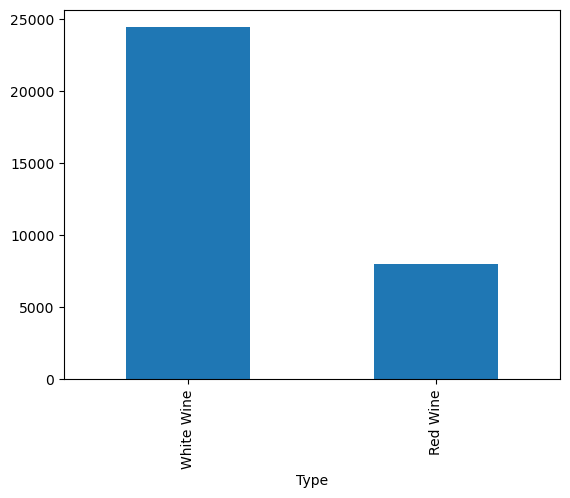

In [5]:
df['Type'].value_counts().plot(kind='bar');


# Dealing with class imbalance:
## Random undersampling of the majority class 
- Random sampling form the majority class 
- Use appropriate statistical methods:
- Specialized tests: Depending on the nature of your data, consider tests designed for imbalanced data, such as the Kruskal-Wallis H Test, Mann-Whitney U test etc..

In [6]:
import pandas as pd
from sklearn.utils import resample

# Separate the dataset into majority and minority classes
white_wine = df[df['Type'] == 'White Wine']
red_wine = df[df['Type'] == 'Red Wine']

# Randomly undersample the majority class (White Wine) to match the size of the minority class (Red Wine)
white_wine_undersampled = resample(white_wine, 
                                   replace=False,     # Without replacement
                                   n_samples=len(red_wine),  # Match minority class size
                                   random_state=42)  # For reproducibility

# Combine the undersampled majority class with the minority class
balanced_df = pd.concat([white_wine_undersampled, red_wine])

# Shuffle the dataset (optional but recommended)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Copy 
df = balanced_df.copy()

df.head()


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,4858,7.3,0.17,0.23,6.3,0.051,35.0,240.0,0.99630,3.36,0.54,10.0,6,White Wine
1,3537,7.4,0.28,0.49,1.5,0.034,20.0,126.0,0.99180,2.98,0.39,10.6,6,White Wine
2,2526,9.9,0.74,0.28,2.6,0.078,21.0,77.0,0.99800,3.28,0.51,9.8,5,Red Wine
3,5910,7.6,0.41,0.49,2.0,0.088,16.0,43.0,0.99800,3.48,0.64,9.1,5,Red Wine
4,4171,7.6,0.43,0.29,2.1,0.075,19.0,66.0,0.99718,3.40,0.64,9.5,5,Red Wine


In [7]:
# Check the distribution
df['Type'].value_counts()


Type
White Wine    8032
Red Wine      8032
Name: count, dtype: int64

# T-test assumptions 

### 1. Independence of Observations:
- The two groups being compared should be independent of each other (no overlap between groups).
- Observations in one group (e.g., red wines) should not influence observations in the other group (e.g., white wines)
- Data collection methods should ensure no dependency (e.g., random sampling).

### 2. Normality:
- The data in each group should follow a normal distribution.
- This assumption is less strict with larger sample sizes due to the Central Limit Theorem (CLT).
### 3. Homogeneity of Variances:
- The variances of the two groups should be equal.
- This can be tested using **`Levene’s test`**. If this assumption is violated, use **`Welch's t-test` (`equal_var=False` in `ttest_ind()`).**


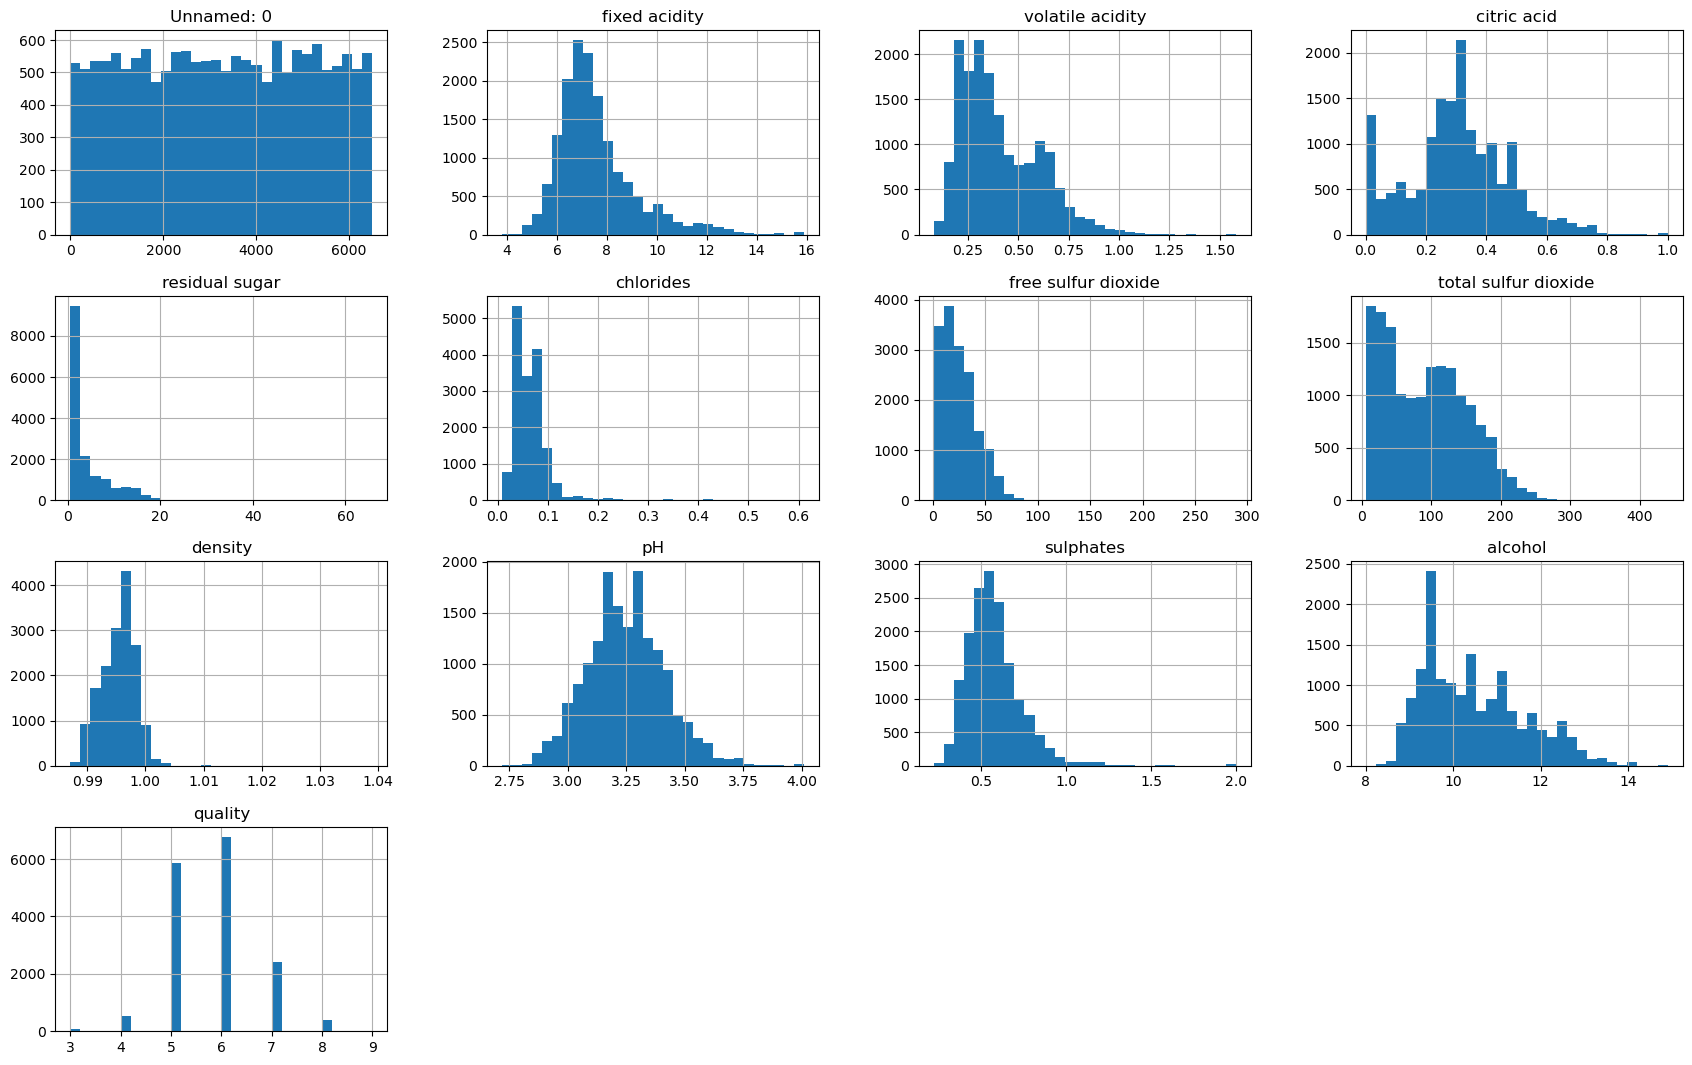

In [8]:
df.hist(bins=30, figsize=(21,13));

## Remove Outliers 

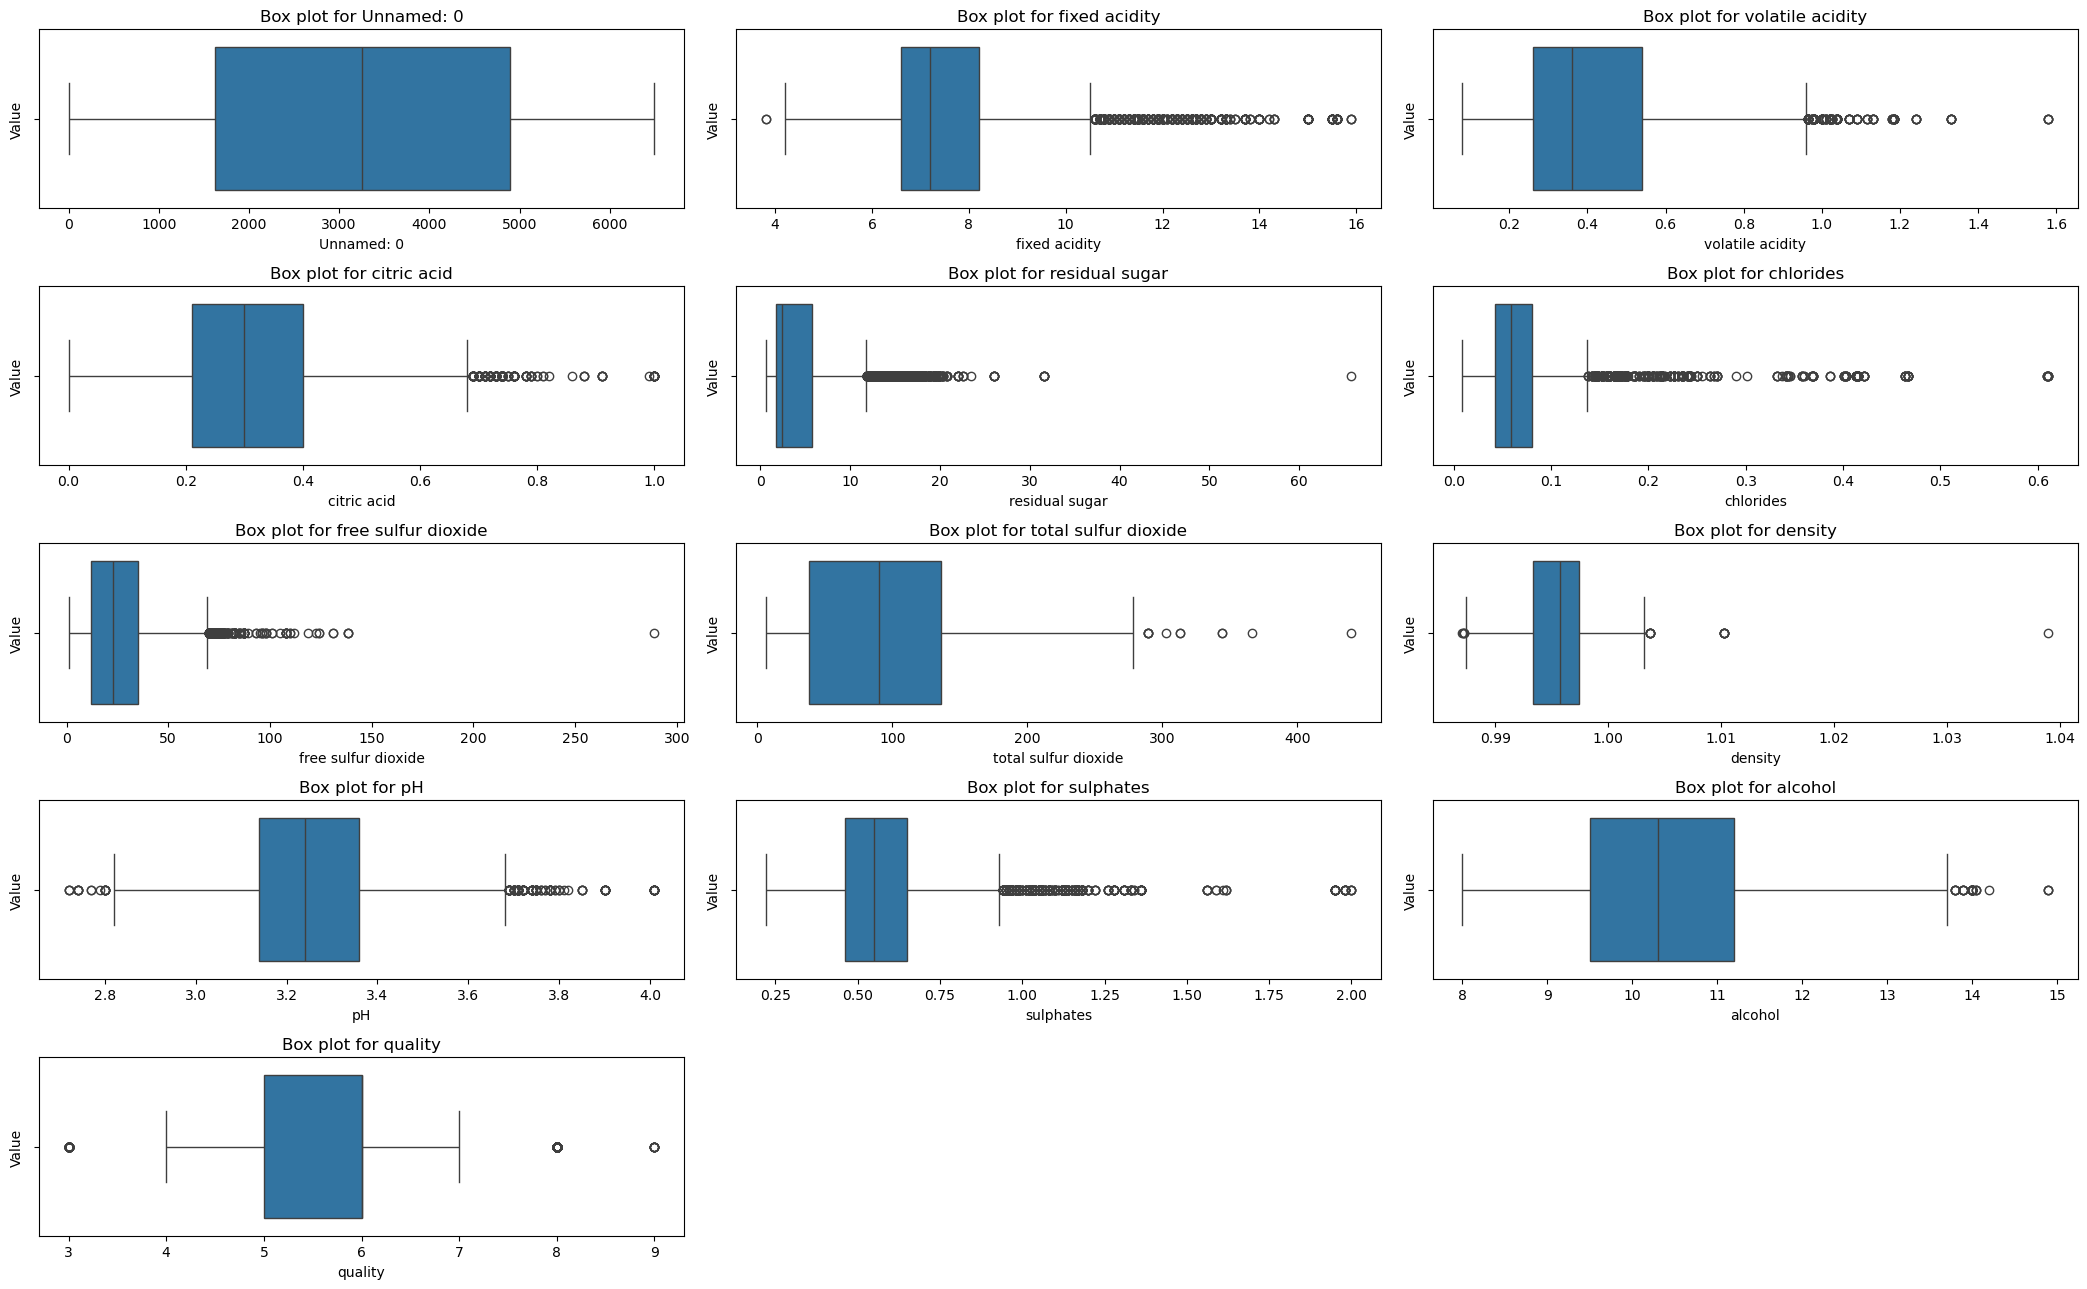

In [9]:
# Only select numeric columns 
numeric_columns = df.select_dtypes(include=['number']).columns[:]

# Grid layout
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(21, 13))


# Flatten 
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df[column], ax = axes[i])
    axes[i].set_title(f"Box plot for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Value')
    
# Hide empty subplots 
for j in range(i + 1, rows * cols):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

### Use IQR to remove outliers 

In [10]:
# Create a copy of the data
data_copy = df.copy()
# Select only numeric columns
numeric_data = data_copy.select_dtypes(include=['number'])

# Calculate q1, q3, and IQR for numeric data only
q1 = numeric_data.quantile(0.10)  # .25
q3 = numeric_data.quantile(0.90)  # .75
IQR = q3 - q1

# Lower and upper bounds for identifying outliers
lower_bound = q1 - (1.5 * IQR)
upper_bound = q3 + (1.5 * IQR)

# Identify outliers in numeric columns
outliers_ = set()
for col in numeric_data.columns:
    outliers = numeric_data[(numeric_data[col] < lower_bound[col]) | (numeric_data[col] > upper_bound[col])]
    outliers_.update(outliers.index)

# Count number of rows before removing outliers
num_rows_before = len(data_copy)

# Remove rows with outliers from the original DataFrame (important!)
data_copy = data_copy.drop(index=outliers_)

# Num of rows after removing outliers
num_rows_after = len(data_copy)

# Number of rows removed
rows_removed = num_rows_before - num_rows_after

# Print the results
print(f"Number of rows before removing outliers: {num_rows_before}")
print(f"Number of rows after removing outliers: {num_rows_after}")
print(f"Number of rows removed: {rows_removed}")

df = data_copy.copy()


Number of rows before removing outliers: 16064
Number of rows after removing outliers: 15730
Number of rows removed: 334


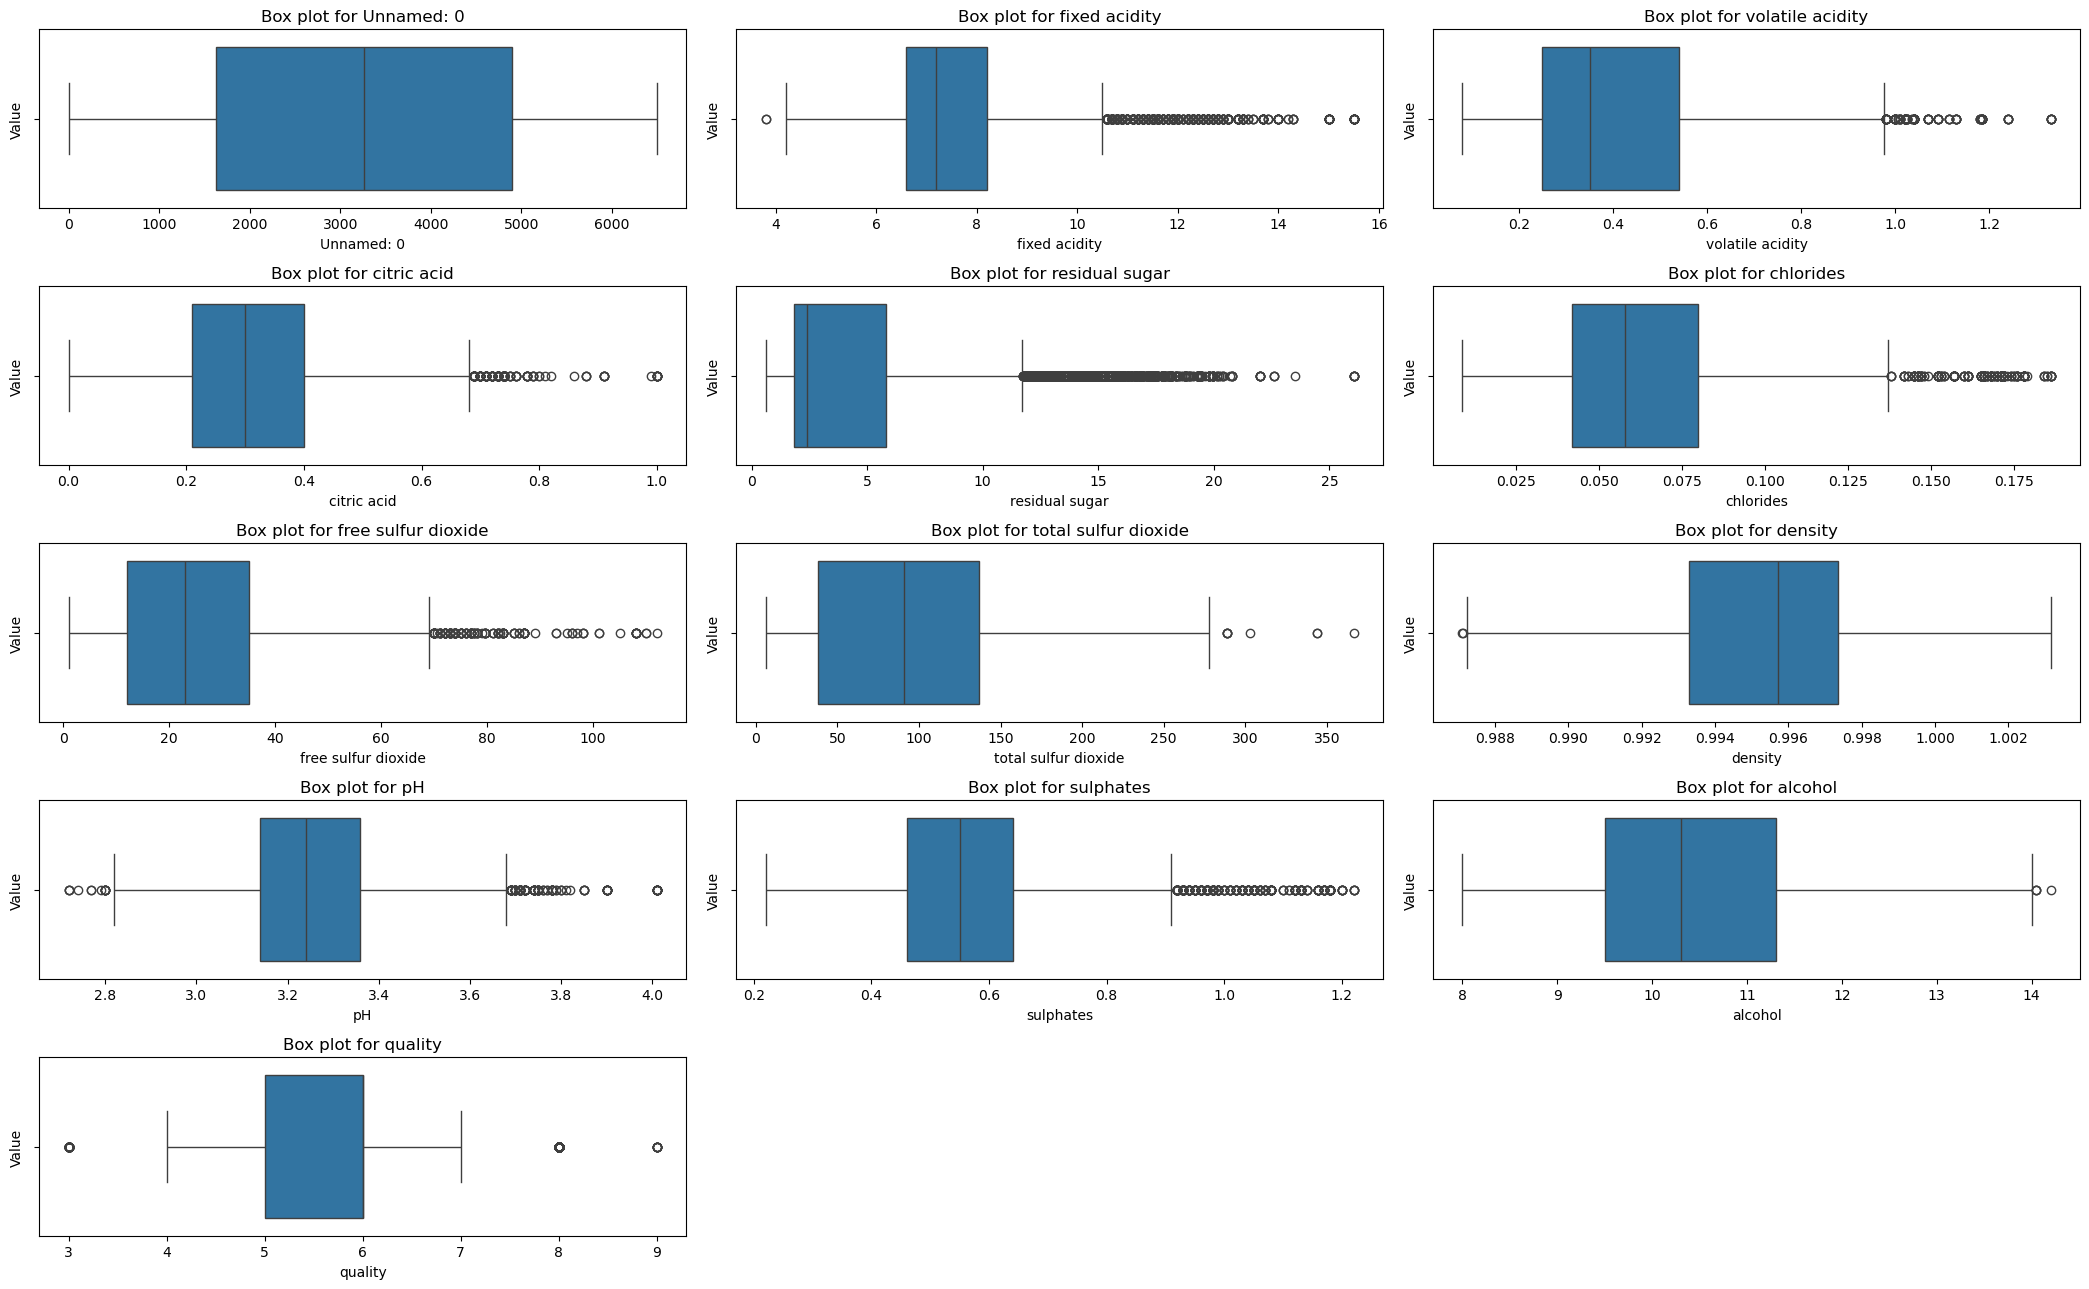

In [11]:
# Grid layout
rows, cols = 5, 3
fig, axes = plt.subplots(rows, cols, figsize=(21, 13))


# Flatten 
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df[column], ax = axes[i])
    axes[i].set_title(f"Box plot for {column}")
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Value')
    
# Hide empty subplots 
for j in range(i + 1, rows * cols):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

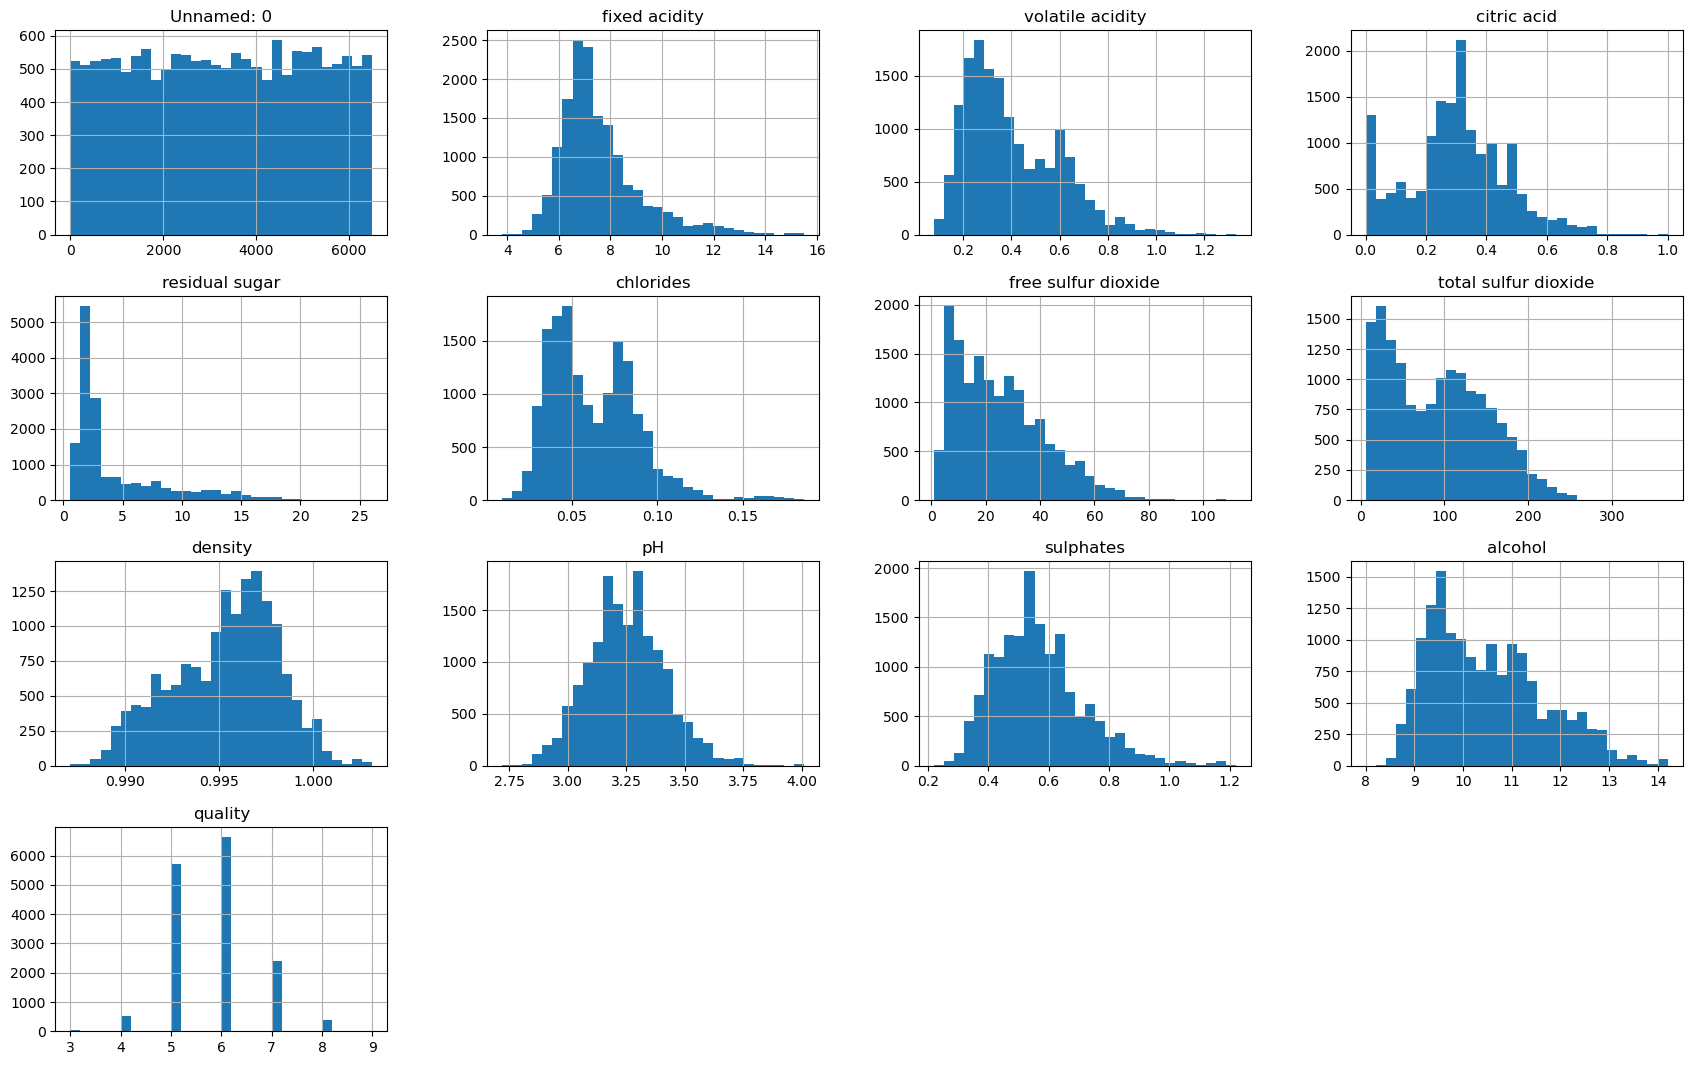

In [12]:
df.hist(bins=30, figsize=(21,13));

# Box cox transformation 

In [13]:
# from scipy.stats import boxcox
# import pandas as pd
# import numpy as np

# # Make a copy of the original DataFrame
# df_boxcox = df.copy()

# # Apply Box-Cox transformation to each numeric column
# for col in df_boxcox.select_dtypes(include=[np.number]).columns:
#     # Ensure all values are positive (Box-Cox requirement)
#     if (df_boxcox[col] <= 0).any():
#         df_boxcox[col] = df_boxcox[col] + abs(df_boxcox[col].min()) + 1
    
#     # Apply Box-Cox transformation
#     df_boxcox[col], _ = boxcox(df_boxcox[col])

# print("Box-Cox Transformation Applied Successfully")
# df = df_boxcox.copy()


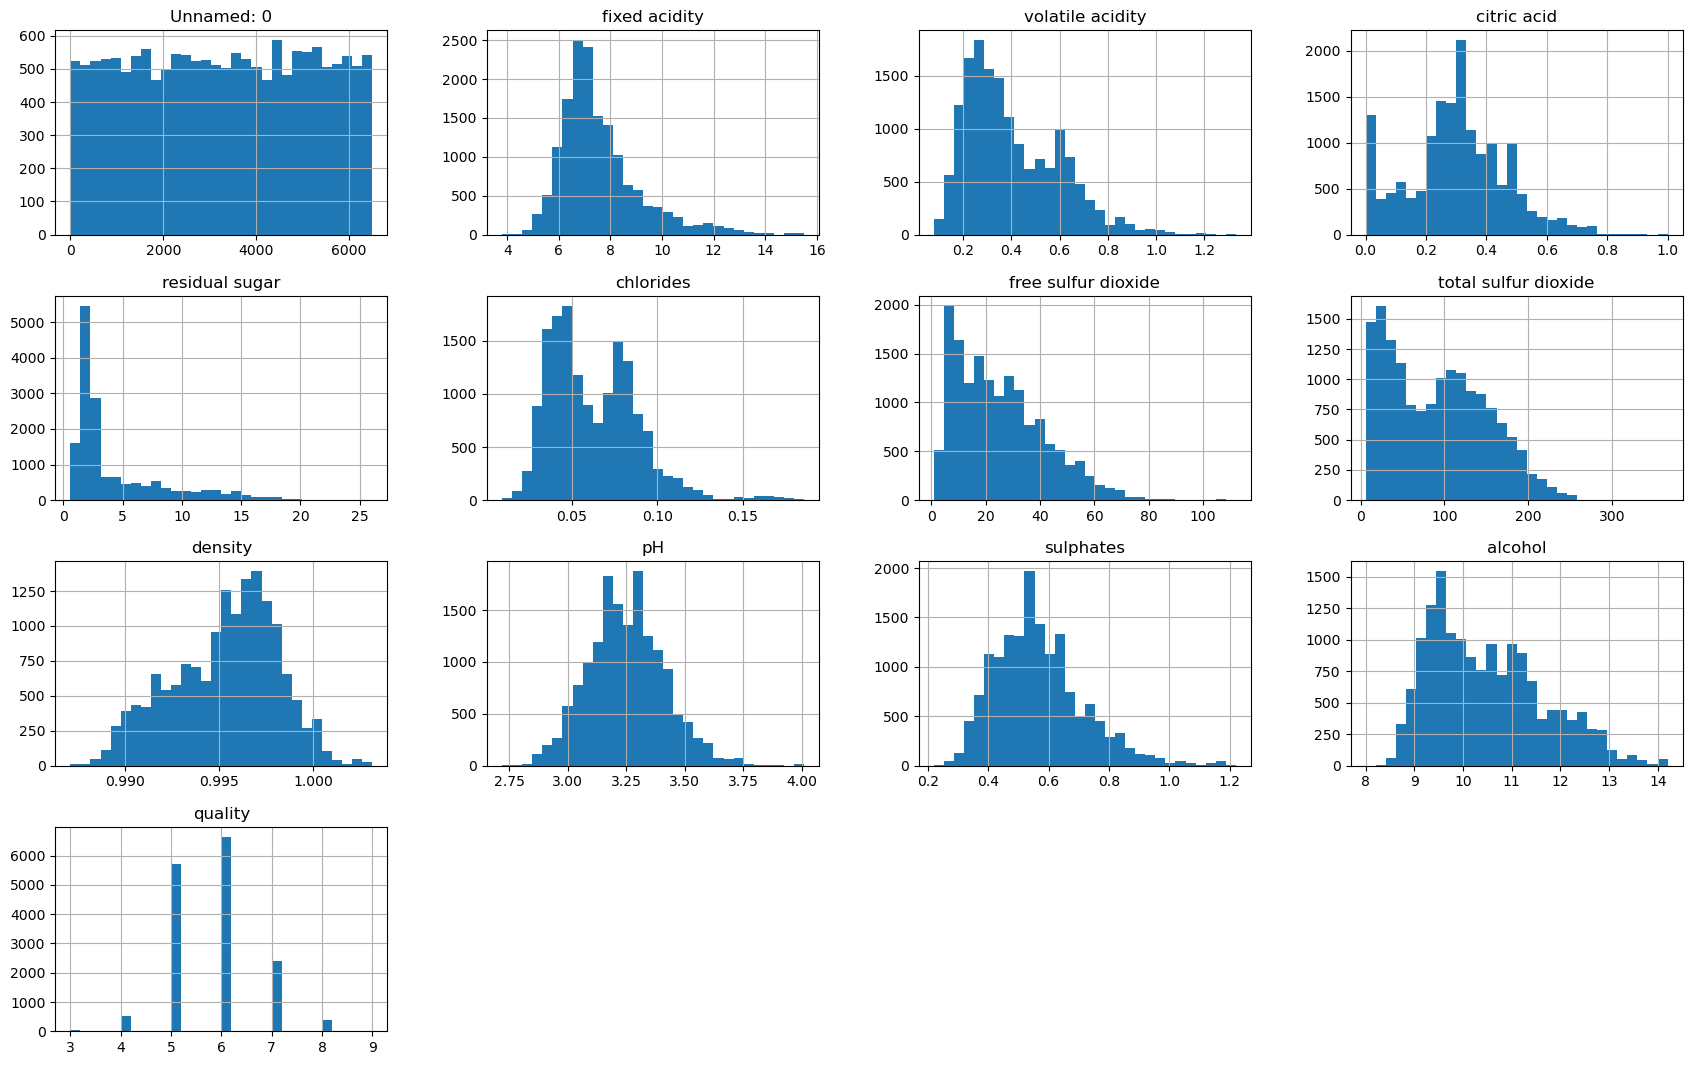

In [14]:
df.hist(bins=30, figsize=(21,13));

## Log transformation 

In [15]:
import pandas as pd
import numpy as np

# Make a copy of the original DataFrame
df_log = df.copy()

# Apply Log transformation to each numeric column
for col in df_log.select_dtypes(include=[np.number]).columns:
    # Ensure all values are positive
    if (df_log[col] <= 0).any():
        df_log[col] = df_log[col] + abs(df_log[col].min()) + 1
    
    # Apply log transformation
    df_log[col] = np.log(df_log[col])

print("Log Transformation Applied Successfully")
df_log.head()


Log Transformation Applied Successfully


,Unnamed: 0,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Type
0,8.488588,1.987874,-1.771957,0.207014,1.840550,-2.975930,3.555348,5.480639,-0.003707,1.211941,-0.616186,2.302585,1.791759,White Wine
1,8.171317,2.001480,-1.272966,0.398776,0.405465,-3.381395,2.995732,4.836282,-0.008234,1.091923,-0.941609,2.360854,1.791759,White Wine
2,7.834788,2.292535,-0.301105,0.246860,0.955511,-2.551046,3.044522,4.343805,-0.002002,1.187843,-0.673345,2.282382,1.609438,Red Wine
3,8.684570,2.028148,-0.891598,0.398776,0.693147,-2.430418,2.772589,3.761200,-0.002002,1.247032,-0.446287,2.208274,1.609438,Red Wine
4,8.336151,2.028148,-0.843970,0.254642,0.741937,-2.590267,2.944439,4.189655,-0.002824,1.223775,-0.446287,2.251292,1.609438,Red Wine


In [16]:
df = df_log.copy()

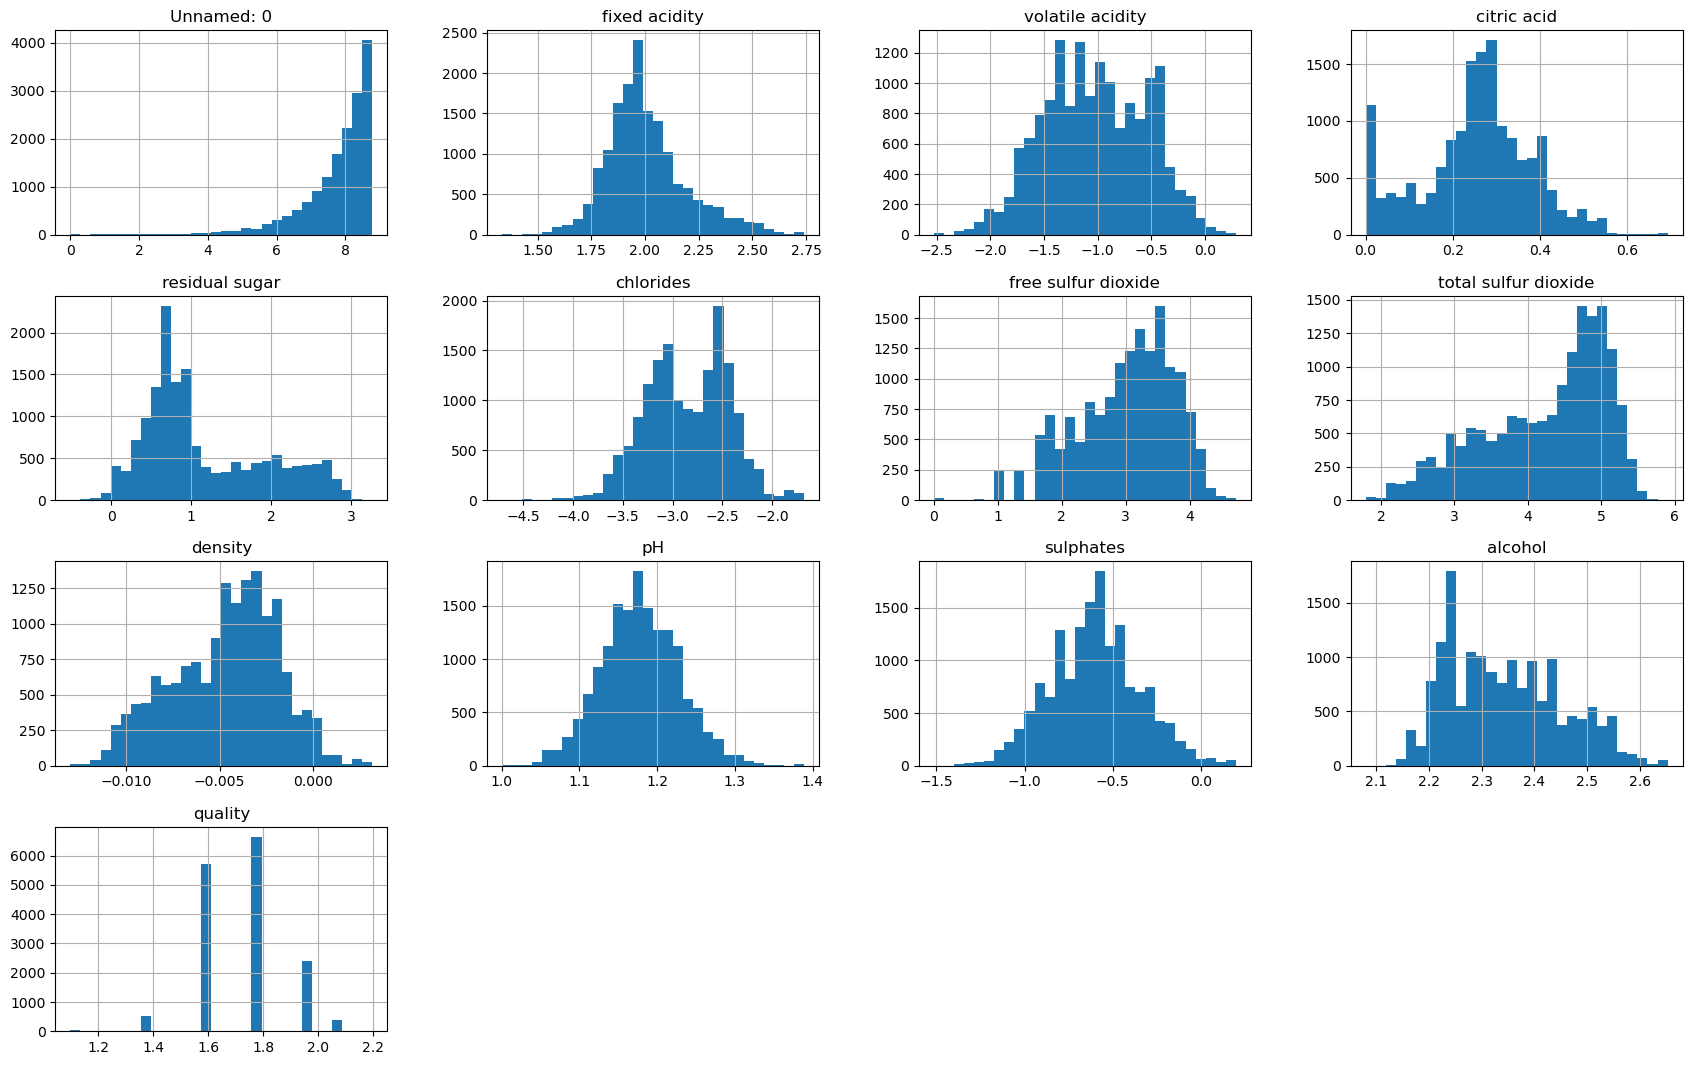

In [17]:
df.hist(bins=30, figsize=(21,13));

In [18]:
df.columns

Index(['Unnamed: 0', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality', 'Type'],
      dtype='object')

# Hypothesis Testing 

 ## 1. Independent Samples t-tests
 - Compare the means of two independent groups to determine if there is a statistically significant difference between them.
 - The groups are considered independent if there is no relationship or overlap between the participants in one group and those in the other.
 
### 1. Setting the hypothesis
#### **Null Hypothesis:** 
- The mean alcohol content of red wines is equal to the mean alcohol content of white wines.
#### **Alternative Hypothesis:** 
- The mean alcohol content of red wines is significantly different from the mean alcohol content of white wines. 
> These hypotheses reflect a two-tailed test, which is appropriate when you are interested in detecting any significant difference between the two groups, regardless of direction (higher or lower).




#### Levene Test for variance 
- **Null Hypothesis (H0):** The variances of red and white wine alcohol content are equal.
- **Alternative Hypothesis (H1):** The variances of red and white wine alcohol content are not equal.

In [19]:
# Perform a levene test to determine if variace is equal among the variables

from scipy.stats import levene

# Separate the alcohol content for red and white wines
red_wine_alcohol = df[df['Type'] == 'Red Wine']['alcohol']
white_wine_alcohol = df[df['Type'] == 'White Wine']['alcohol']

# Check for equality of variances using Levene's test
stat, p_var = levene(red_wine_alcohol, white_wine_alcohol)

print(f"Levene's Test Statistic: {stat:.2f}")
print(f"Levene's Test P-Value: {p_var:.4f}")

Levene's Test Statistic: 283.73
Levene's Test P-Value: 0.0000




- With a p-value of 0.00 you reject the null hypothesis. This means there is strong evidence that the variances of the two groups are significantly different.

- Therefore you should perform Welch’s t-test **`(set equal_var=False in ttest_ind())`**. 

In [20]:
from scipy.stats import ttest_ind # Independent t-test 


# Separate the alcohol content for red and white wines
red_wine_alcohol = df[df['Type'] == 'Red Wine']['alcohol']
white_wine_alcohol = df[df['Type'] == 'White Wine']['alcohol']

# Perform an independent samples t-test
t_stat, p_value = ttest_ind(red_wine_alcohol, white_wine_alcohol, equal_var=False)  # Welch's T-Test

# Print the results
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

alpha = 0.05

if p_value <= alpha:
    print("Reject the null hypothesis (H0). There is a significant difference in alcohol content between red and white wines.")
else:
    print("Fail to reject the null hypothesis (H0). There is no significant difference in alcohol content between red and white wines.")



T-Statistic: -4.200130779362178
P-Value: 2.6825322005981278e-05
Reject the null hypothesis (H0). There is a significant difference in alcohol content between red and white wines.


## 2. A Paired Samples t-test(dependent t-test) 
- Used to compare the means of two related groups or measurements. The groups are considered "paired" because the data in one group corresponds directly to the data in the other group (e.g two measurements on the same wine sample - free and total sulphur in wine).

### Hypotheses for the Paired Samples t-test:
- **Null Hypothesis:** The mean free sulfur dioxide level is equal to the mean total sulfur dioxide level in red wine.
- **Alternative Hypothesis** The mean free sulfur dioxide level is different from the mean total sulfur dioxide level in red wine.


#### 1. Levene test

In [21]:
# Filter red wines
red_wines = df[df['Type'] == 'Red Wine']

# Extract paired data
total_sulfur = red_wines['total sulfur dioxide']
free_sulfur = red_wines['free sulfur dioxide']

# Step 1: Levene's Test for variance
levene_stat, levene_p = levene(total_sulfur, free_sulfur)

print("Levene's Test for Equality of Variances:")
print(f"Statistic: {levene_stat:.4f}, p-value: {levene_p:.4f}")
if levene_p < 0.05:
    print("Variances are significantly different (p < 0.05).")
else:
    print("Variances are not significantly different (p >= 0.05).")


Levene's Test for Equality of Variances:
Statistic: 2.1185, p-value: 0.1456
Variances are not significantly different (p >= 0.05).


- Statistic: 2.1185, p-value: 0.1456: The p-value is greater than 0.05, so you fail to reject the null hypothesis of Levene's test.
#### Conclusion: 
- Variances are not significantly different. This means the assumption of equal variances holds.

In [22]:
from scipy.stats import ttest_rel # Paired Samples t-test


# Filter red wines
red_wines = df[df['Type'] == 'Red Wine']

# Extract paired data
total_sulfur = red_wines['total sulfur dioxide']
free_sulfur = red_wines['free sulfur dioxide']

# Perform paired samples t-test
t_stat, p_value = ttest_rel(total_sulfur, free_sulfur)

# Print results
print("T-Statistic:", t_stat)
print("P-Value:", p_value)

# Decision Rule
alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis (H₀). There is a significant difference between total and free sulfur dioxide levels in red wines.")
else:
    print("Fail to reject the null hypothesis (H₀). There is no significant difference between total and free sulfur dioxide levels in red wines.")


T-Statistic: 201.60175535019417
P-Value: 0.0
Reject the null hypothesis (H₀). There is a significant difference between total and free sulfur dioxide levels in red wines.


### Conclusion
- There is strong statistical evidence to conclude that the mean alcohol content of red wines is significantly different from the mean alcohol content of white wines.

## 3. Single-Sample t-tests 

- Determine whether the mean of a single sample is significantly different from a known or hypothesized population mean.
- Is used to test if the sample mean is equal to a specific value (benchmark or population mean).
- Determining if the pH in a sample of wine differs from a known industry standard.


### Setting the hypothesis

- **Null Hypothesis:** The mean pH level of the sample is equal to 3.5.
- **Alternative Hypothesis:** The mean pH level of the sample is different from 3.5.
- This is a two-tailed test since we are testing for any difference from 3.5.


In [23]:
from scipy.stats import ttest_1samp # calculates the T-test for the mean of ONE group of scores.

# Define benchmark mean
benchmark_mean = 3.5  # Replace with your actual benchmark value

# Filter red and white wines for pH levels
red_wines_pH = df[df['Type'] == 'Red Wine']['pH']
white_wines_pH = df[df['Type'] == 'White Wine']['pH']

# Perform one-sample t-test for red wines
red_t_stat, red_p_value = ttest_1samp(red_wines_pH, benchmark_mean)

# Perform one-sample t-test for white wines
white_t_stat, white_p_value = ttest_1samp(white_wines_pH, benchmark_mean)

# Print results for red wines
print("Red Wines pH:")
print(f"T-Statistic: {red_t_stat:.4f}, p-value: {red_p_value:.4f}")
if red_p_value < 0.05:
    print("Reject the null hypothesis (H₀). The mean pH of red wines is significantly different from the benchmark.")
else:
    print("Fail to reject the null hypothesis (H₀). The mean pH of red wines is not significantly different from the benchmark.")

# Print results for white wines
print("\nWhite Wines pH:")
print(f"T-Statistic: {white_t_stat:.4f}, p-value: {white_p_value:.4f}")
if white_p_value < 0.05:
    print("Reject the null hypothesis (H₀). The mean pH of white wines is significantly different from the benchmark.")
else:
    print("Fail to reject the null hypothesis (H₀). The mean pH of white wines is not significantly different from the benchmark.")


Red Wines pH:
T-Statistic: -4446.7029, p-value: 0.0000
Reject the null hypothesis (H₀). The mean pH of red wines is significantly different from the benchmark.

White Wines pH:
T-Statistic: -4448.4163, p-value: 0.0000
Reject the null hypothesis (H₀). The mean pH of white wines is significantly different from the benchmark.
